In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_2014 = pd.read_csv('//content/drive/MyDrive/dataset_2014_corrected.csv')
df_2014 = df_2014.rename(columns={'docTypeByOP':'art',
                                  'textOCR':'text'} )
df_2014 = df_2014[df_2014['art'].isin(['Постановление', 'Распоряжение', 'Закон', 'Указ', 'Федеральный закон'])]
df_2014 = df_2014[:2000]
df_2014

,art,text
1,Постановление,правительство забайкальского края постановлени...
2,Распоряжение,правительство российской федерации распоряжени...
3,Постановление,а1истрация тамбовской области постановление ек...
4,Постановление,правительство рязанской области постановление ...
5,Распоряжение,правительство российской федерацш распоряжение...
...,...,...
2062,Постановление,правительство удмуртской республики удмурт эль...
2063,Распоряжение,правительство российской федерашш распоряжение...
2064,Постановление,. ч........ г проюшпьная часы 0 801000 044984....
2065,Распоряжение,распоряжение президента российской федерации о...


In [5]:
df_2014['art'].value_counts()

Постановление        1140
Распоряжение          389
Закон                 239
Указ                  155
Федеральный закон      77
Name: art, dtype: int64

In [6]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

токенизация и паддинг - сильно сократила их длину, чтобы не вылетала ошибка

In [7]:

tokenized = df_2014['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_short = [i[:99] for i in tokenized]
max_len = 100
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_short])
np.array(padded).shape

Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


(2000, 100)

маска чтобы показать, какие токены игнорируются

In [8]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 100)

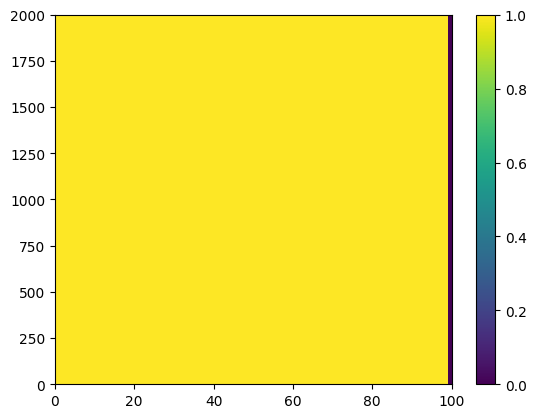

In [9]:
import matplotlib.pyplot as plt

plt.pcolormesh(attention_mask)
plt.colorbar()

видно, что почи ничего не будет игнорироваться))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [11]:
input_ids = torch.tensor(padded).to(device)
attention_mask = torch.tensor(attention_mask).to(device)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [12]:
features = last_hidden_states[0][:,0,:]
features = features.cpu().numpy()
labels = df_2014['art']

разделить на трейновую, тестовую и валидационную выборку

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(features, labels,  test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(X_train[:1000], y_train[:1000])

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 15.789557894736841}
best scrores:  0.9669999999999999


In [19]:
lr_clf = LogisticRegression(C=15.79).fit(X_train, y_train)

In [20]:
from sklearn import metrics
predicted_log_reg = lr_clf.predict(X_test)
print(metrics.classification_report(predicted_log_reg, y_test))

                   precision    recall  f1-score   support

            Закон       0.94      1.00      0.97        34
    Постановление       0.99      0.99      0.99       211
     Распоряжение       0.99      0.97      0.98        70
             Указ       0.97      1.00      0.98        28
Федеральный закон       1.00      0.94      0.97        17

         accuracy                           0.98       360
        macro avg       0.98      0.98      0.98       360
     weighted avg       0.98      0.98      0.98       360



In [21]:
predicted_log_reg_v = lr_clf.predict(X_valid)
print(metrics.classification_report(predicted_log_reg_v, y_valid))

                   precision    recall  f1-score   support

            Закон       0.88      0.95      0.91        22
    Постановление       1.00      0.98      0.99       107
     Распоряжение       0.95      0.95      0.95        42
             Указ       0.90      0.95      0.92        19
Федеральный закон       1.00      0.90      0.95        10

         accuracy                           0.96       200
        macro avg       0.95      0.95      0.95       200
     weighted avg       0.97      0.96      0.97       200



регрессия показывает довольно хорошие результаты, в том числе и на валидационной выборке, но предсказания разных классов не сбалансированы

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


In [23]:
sgd_ppl_clf = Pipeline([

    ('sgd_clf', SGDClassifier(random_state=42))
])

parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet']
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])

In [24]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

Best score and parameter combination:
0.941 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'perceptron', 'sgd_clf__penalty': None}


In [25]:
sgd = SGDClassifier(loss='perceptron', penalty=None, class_weight='balanced')
sgd.fit(X_train, y_train)

SGDClassifier(class_weight='balanced', loss='perceptron', penalty=None)

In [26]:
predicted_sgd = sgd.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

            Закон       0.81      0.91      0.85        32
    Постановление       0.98      0.97      0.97       211
     Распоряжение       0.99      0.96      0.97        71
             Указ       0.86      0.93      0.89        27
Федеральный закон       0.94      0.79      0.86        19

         accuracy                           0.95       360
        macro avg       0.91      0.91      0.91       360
     weighted avg       0.95      0.95      0.95       360



In [27]:
predicted_sgd = sgd.predict(X_valid)
print(metrics.classification_report(predicted_sgd, y_valid))

                   precision    recall  f1-score   support

            Закон       0.79      0.90      0.84        21
    Постановление       0.98      0.94      0.96       110
     Распоряжение       0.93      0.93      0.93        42
             Указ       0.80      0.94      0.86        17
Федеральный закон       1.00      0.90      0.95        10

         accuracy                           0.93       200
        macro avg       0.90      0.92      0.91       200
     weighted avg       0.94      0.93      0.93       200



Предсказания разных классов также не сбалансированны по точности

Теперь попробуем не с укороченным датасетом

In [39]:
df_2014 = pd.read_csv('//content/drive/MyDrive/dataset_2014_corrected.csv')
df_2014 = df_2014.rename(columns={'docTypeByOP':'art',
                                  'textOCR':'text'} )
df_2014 = df_2014[df_2014['art'].isin(['Постановление', 'Распоряжение', 'Закон', 'Указ', 'Федеральный закон'])]
df_2014['art'].value_counts()

Постановление        8378
Распоряжение         2676
Закон                1530
Указ                 1047
Федеральный закон     535
Name: art, dtype: int64

In [44]:
tokenized_texts = df_2014['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)).values

max_len = max(len(text) for text in tokenized_texts)
padded_texts = torch.tensor([text + [0] * (max_len - len(text)) for text in tokenized_texts])

attention_mask = torch.where(padded_texts > 0, 1, 0)

In [30]:
gpu_num = 0
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [32]:
import numpy as np
model = model_class.from_pretrained(pretrained_weights)
model.to(device)
batch_size = 16
features = []
with torch.no_grad():
    for i in range(0, len(padded_texts), batch_size):
        texts_batch = padded_texts[i : i + batch_size].to(device)
        mask_batch = attention_mask[i : i + batch_size].to(device)
        output = model(texts_batch, mask_batch)
        batch_features = output.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)

features = np.concatenate(features, axis=0)
features.shape

(14166, 768)

In [33]:
labels = df_2014['art'].values

X_train, X_valid, y_train, y_valid = train_test_split(features, labels,  test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [34]:

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(X_train[:1000], y_train[:1000])

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 21.05271052631579}
best scrores:  0.9639999999999999


In [35]:
lr_clf = LogisticRegression(C=21.05).fit(X_train, y_train)

In [36]:
predicted_log_reg = lr_clf.predict(X_test)
print(metrics.classification_report(predicted_log_reg, y_test))

                   precision    recall  f1-score   support

            Закон       0.92      0.94      0.93       270
    Постановление       0.99      0.97      0.98      1513
     Распоряжение       0.95      0.97      0.96       467
             Указ       0.89      0.96      0.93       198
Федеральный закон       0.95      0.95      0.95       102

         accuracy                           0.97      2550
        macro avg       0.94      0.96      0.95      2550
     weighted avg       0.97      0.97      0.97      2550



In [37]:
predicted_log_reg_v = lr_clf.predict(X_valid)
print(metrics.classification_report(predicted_log_reg_v, y_valid))

                   precision    recall  f1-score   support

            Закон       0.96      0.89      0.92       155
    Постановление       0.98      0.98      0.98       878
     Распоряжение       0.92      0.97      0.94       236
             Указ       0.92      0.94      0.93        98
Федеральный закон       0.94      0.92      0.93        50

         accuracy                           0.96      1417
        macro avg       0.94      0.94      0.94      1417
     weighted avg       0.96      0.96      0.96      1417



Предсказания стали более сбалансированными

Теперь с SGD:

In [38]:
sgd_ppl_clf = Pipeline([

    ('sgd_clf', SGDClassifier(random_state=42))
])

parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet']
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])

In [40]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

Best score and parameter combination:
0.9249999999999999 {'sgd_clf__class_weight': None, 'sgd_clf__loss': 'log', 'sgd_clf__penalty': None}


In [41]:
sgd = SGDClassifier(loss='log', penalty=None)
sgd.fit(X_train, y_train)

SGDClassifier(loss='log', penalty=None)

In [42]:
predicted_sgd = sgd.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

            Закон       0.91      0.96      0.93       264
    Постановление       0.99      0.97      0.98      1506
     Распоряжение       0.95      0.97      0.96       468
             Указ       0.93      0.94      0.93       211
Федеральный закон       0.94      0.95      0.95       101

         accuracy                           0.96      2550
        macro avg       0.94      0.96      0.95      2550
     weighted avg       0.96      0.96      0.96      2550



In [43]:
predicted_sgd = sgd.predict(X_valid)
print(metrics.classification_report(predicted_sgd, y_valid))

                   precision    recall  f1-score   support

            Закон       0.95      0.93      0.94       148
    Постановление       0.98      0.97      0.98       883
     Распоряжение       0.91      0.97      0.94       232
             Указ       0.96      0.91      0.93       106
Федеральный закон       0.94      0.96      0.95        48

         accuracy                           0.96      1417
        macro avg       0.95      0.95      0.95      1417
     weighted avg       0.96      0.96      0.96      1417



Предсказания разных классов также выровнялись


Вывод: использование BERT перед подачей классификатору повышает точность результата.
Также можно предположить, что релевантная для классификации информация содержится в начале текста - что неудивительно, т к это соответствует реальной структуре юридического документа